# Small footprint proof of concept

The goal here is to test to what extent we can segment Ocean Parcels calculations.  In particular, can we run a long time span calculation trajectory calculation only having access to only a small subset of files at any given time.  This has two significant benefits:
1. smaller local storage is needed as input files are rotated in and out of the Fieldset and
2. smaller RAM is needed to store trajectory outputs since particle positions are written out incrementally.

Below, we run two cases:
1. Reference case (**ref**): OceanParcels has access to everything and runs all trajectories all at once,
2. Incremental file read and incremental data write (**irw**): OceanParcels only can see the files it needs for each step and spits out trajectories incrementally.

It seems that OceanParcels *by default* incrementally writes output to the out-XXXXX/NNN.npy files. However, it seems to be appending subsets of the particles to each file and also creating new files as time progresses.  Fewer files are created for shorter duration runs but for the long runs, the time stamps are all up to current time suggesting that even though files are created incrementally, nearly all files are still written to over the course of the run.  It may be that older files are only being appended linking information (which files their data spills over to) in an effort to keep all files about the same size. The [OceanParcels output tutorial](https://nbviewer.jupyter.org/github/OceanParcels/parcels/blob/master/parcels/examples/tutorial_output.ipynb) does not elaborate on this point so will need to search elsewhere for the specifics on this.

## Dependencies

We start with importing the relevant modules

In [1]:
from parcels import FieldSet, ParticleSet, JITParticle, AdvectionRK4, ErrorCode
from datetime import timedelta
import numpy as np
import os
import netCDF4

INFO: Compiled ParcelsRandom ==> /tmp/parcels-40545/libparcels_random_a2d8904a-fe79-418c-9a5b-78c1180811ed.so


***
# Reference case

## Input velocity fields for reference case

We will use the Globcurrent fields from the `GlobCurrent_example_data` directory leveraging the fact that all filenames are nearly the same format with `<YYYY><MM><DD><HH><MM><SS>-GLOBCURRENT...`.  In this case, it is pretty simple because all files represent 1 day at the same time each day (uniform time increment).  Right here, note that OceanParcels has access to all files for this baseline case.

In [2]:
filenames = "/pw/workflows/ocean_parcels_demo/parcels_examples/GlobCurrent_example_data/20*.nc"
variables = {'U': 'eastward_eulerian_current_velocity',
             'V': 'northward_eulerian_current_velocity'}
dimensions = {'lat': 'lat',
              'lon': 'lon',
              'time': 'time'}
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)

## Initialize particle set

Now create vectors of Longitude and Latitude starting locations on a regular mesh, and use these to initialise a `ParticleSet` object.

In [3]:
lons, lats = np.meshgrid(range(15, 35), range(-40, -30))
pset = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lons, lat=lats)

## Output file for reference case

Specify the file name and output time step

In [4]:
ref_out_file = pset.ParticleFile(name="ref.nc", outputdt=timedelta(hours=24))

Now we want to advect the particles. However, the Globcurrent data that we loaded in is only for a limited, regional domain and particles might be able to leave this domain. We therefore need to tell Parcels that particles that leave the domain need to be deleted. We do that using a `Recovery Kernel`, which will be invoked when a particle encounters an `ErrorOutOfBounds` error:

In [5]:
def DeleteParticle(particle, fieldset, time):
    particle.delete()
    
def StopParticle(particle, fieldset, time):
    particle.stop()

## Advect particles for reference case

Now we can advect the particles. Note that we do this inside a `for`-loop, so we can save a plot every six hours (which is the value of `runtime`).

In [6]:
# Inputs: pset, DeleteParticle
# Outputs: list of files (each file name is in savefile)
#for cnt in range(10):
    # Set filename for output plot
    #output_image = 'particles'+str(cnt).zfill(2)
    #print(output_image)
    
    # First plot the particles
    #pset.show(savefile=output_image, field='vector', land=True, vmax=2.0)

    # Then advect the particles for 24 hours (to match file increment)
#    pset.execute(AdvectionRK4,
#                 runtime=timedelta(hours=24),  # runtime controls the interval of the plots
#                 dt=timedelta(minutes=5),
#                 output_file=ref_out_file,
#                 recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})  # the recovery kernel
    
pset.execute(AdvectionRK4,
    runtime=timedelta(days=10),  # runtime controls the interval of the plots
    dt=timedelta(minutes=5),
    output_file=ref_out_file,
    recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})  # the recovery kernel

INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-40545/77e0ce0c23c1641ac0311babad7ff13d_0.so


## Write output file for reference case
Running this again will overwrite any existing .nc file with the same name.

In [7]:
#ref_out_file.close()  # Will destroy the *.npy source files after coalescing
ref_out_file.export()  # Will coalesce the *.npy source files and keep them

***
# Incremental data access

Now we copy over files to the current working directory to ensure only subsets of files are "available" at a given time.  This simulates the process of sending files just in time to the worker, thus allowing for a smaller worker footprint and potentially running data transfer at the same time as the calculation.

At its core, OceanParcels uses `np.save('file.npy',var)` in `parcels.particlefile.baseparticlefile` to save variables which will preserve the precision stored in memory.  This has the potential to reduce chaotic effects of small offsets between trajectories allowing for the same trajectories to be computed incrementally as they are computed all in one go.



## Input velocity fields for the incremental read case
The `variables` and `dimensions` field specifications set above do not need to change.  Reset `filenames` to match the current working directory.

In [8]:
filenames = "20*.nc"

## Incremental loop
For each iteration of the loop, we need to repeat the separate steps executed above:
1. Copy over relevant files
2. Initialize the FieldSet
3. Initialize the ParticleSet
4. Initialize the incremental file
5. Advect the ParticleSet
6. Save the incremental file

In [9]:
# Inputs: pset, DeleteParticle
# Outputs: list of files (each file name is in savefile)
for cnt in range(10):
    # Set infile files
    basename = "/pw/workflows/ocean_parcels_demo/parcels_examples/GlobCurrent_example_data/200201"
    endname = "000000-GLOBCURRENT-L4-CUReul_hs-ALT_SUM-v02.0-fv01.0.nc"
    infile1 = basename+str(cnt+1).zfill(2)+endname
    infile2 = basename+str(cnt+2).zfill(2)+endname
    print("-------------------------------")
    print("Working on files: ")
    print(infile1)
    print(infile2)
    
    # Copy the two files in this working directory so we can make a particle set
    err = os.system("cp "+infile1+" ./")
    err = os.system("cp "+infile2+" ./")

    # Initialize the FieldSet
    fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)
    
    # Initialize the ParticleSet
    # Note launch locations are initialized above and will be
    # updated with end of this run based on outputs created here.
    pset = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lons, lat=lats)
    
    # Initialize the output file
    irw_out_file_name = "irw"+str(cnt+1).zfill(2)+".nc"
    irw_out_file = pset.ParticleFile(name=irw_out_file_name, outputdt=timedelta(hours=24))
    
    # Advect the particles for 24 hours
    pset.execute(AdvectionRK4,
                 runtime=timedelta(hours=24),  # runtime controls the interval of the plots
                 dt=timedelta(minutes=5),
                 output_file=irw_out_file,
                 recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})  # the recovery kernel
    
    # Coalesce data
    irw_out_file.export()
    
    # Update lons and lats by loading final
    # points from the output file.
    irw_out_data = netCDF4.Dataset(irw_out_file_name)
    ids = irw_out_data.variables["trajectory"][:][:,0]
    lons = irw_out_data.variables["lon"][:][:,-1]
    lats = irw_out_data.variables["lat"][:][:,-1]
    
    # Clean up by removing current files (can do this more 
    # intelligently by moving only one file at a time, etc.)
    err = os.system("rm -f 20*.nc")
    

-------------------------------
Working on files: 
/pw/workflows/ocean_parcels_demo/parcels_examples/GlobCurrent_example_data/20020101000000-GLOBCURRENT-L4-CUReul_hs-ALT_SUM-v02.0-fv01.0.nc
/pw/workflows/ocean_parcels_demo/parcels_examples/GlobCurrent_example_data/20020102000000-GLOBCURRENT-L4-CUReul_hs-ALT_SUM-v02.0-fv01.0.nc


INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-40545/116f4526906c4a6c26229cce5ce4b772_0.so


-------------------------------
Working on files: 
/pw/workflows/ocean_parcels_demo/parcels_examples/GlobCurrent_example_data/20020102000000-GLOBCURRENT-L4-CUReul_hs-ALT_SUM-v02.0-fv01.0.nc
/pw/workflows/ocean_parcels_demo/parcels_examples/GlobCurrent_example_data/20020103000000-GLOBCURRENT-L4-CUReul_hs-ALT_SUM-v02.0-fv01.0.nc


INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-40545/6b368347206e22305fccde28a0b87369_0.so


-------------------------------
Working on files: 
/pw/workflows/ocean_parcels_demo/parcels_examples/GlobCurrent_example_data/20020103000000-GLOBCURRENT-L4-CUReul_hs-ALT_SUM-v02.0-fv01.0.nc
/pw/workflows/ocean_parcels_demo/parcels_examples/GlobCurrent_example_data/20020104000000-GLOBCURRENT-L4-CUReul_hs-ALT_SUM-v02.0-fv01.0.nc


INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-40545/862ae23ff802831769a08d8d12ac7c81_0.so


-------------------------------
Working on files: 
/pw/workflows/ocean_parcels_demo/parcels_examples/GlobCurrent_example_data/20020104000000-GLOBCURRENT-L4-CUReul_hs-ALT_SUM-v02.0-fv01.0.nc
/pw/workflows/ocean_parcels_demo/parcels_examples/GlobCurrent_example_data/20020105000000-GLOBCURRENT-L4-CUReul_hs-ALT_SUM-v02.0-fv01.0.nc


INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-40545/9b605c382ee09a4a702ac6401adc6012_0.so


-------------------------------
Working on files: 
/pw/workflows/ocean_parcels_demo/parcels_examples/GlobCurrent_example_data/20020105000000-GLOBCURRENT-L4-CUReul_hs-ALT_SUM-v02.0-fv01.0.nc
/pw/workflows/ocean_parcels_demo/parcels_examples/GlobCurrent_example_data/20020106000000-GLOBCURRENT-L4-CUReul_hs-ALT_SUM-v02.0-fv01.0.nc


INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-40545/4008734613274470a1cbc6ef3555a237_0.so


-------------------------------
Working on files: 
/pw/workflows/ocean_parcels_demo/parcels_examples/GlobCurrent_example_data/20020106000000-GLOBCURRENT-L4-CUReul_hs-ALT_SUM-v02.0-fv01.0.nc
/pw/workflows/ocean_parcels_demo/parcels_examples/GlobCurrent_example_data/20020107000000-GLOBCURRENT-L4-CUReul_hs-ALT_SUM-v02.0-fv01.0.nc


INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-40545/91faa7c851f2897efd83b464356086c3_0.so


-------------------------------
Working on files: 
/pw/workflows/ocean_parcels_demo/parcels_examples/GlobCurrent_example_data/20020107000000-GLOBCURRENT-L4-CUReul_hs-ALT_SUM-v02.0-fv01.0.nc
/pw/workflows/ocean_parcels_demo/parcels_examples/GlobCurrent_example_data/20020108000000-GLOBCURRENT-L4-CUReul_hs-ALT_SUM-v02.0-fv01.0.nc


INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-40545/1833e67460b1a11df99f4c1d704ce96b_0.so


-------------------------------
Working on files: 
/pw/workflows/ocean_parcels_demo/parcels_examples/GlobCurrent_example_data/20020108000000-GLOBCURRENT-L4-CUReul_hs-ALT_SUM-v02.0-fv01.0.nc
/pw/workflows/ocean_parcels_demo/parcels_examples/GlobCurrent_example_data/20020109000000-GLOBCURRENT-L4-CUReul_hs-ALT_SUM-v02.0-fv01.0.nc


INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-40545/37a2f3551e075d14543eaaf0d0b41a44_0.so


-------------------------------
Working on files: 
/pw/workflows/ocean_parcels_demo/parcels_examples/GlobCurrent_example_data/20020109000000-GLOBCURRENT-L4-CUReul_hs-ALT_SUM-v02.0-fv01.0.nc
/pw/workflows/ocean_parcels_demo/parcels_examples/GlobCurrent_example_data/20020110000000-GLOBCURRENT-L4-CUReul_hs-ALT_SUM-v02.0-fv01.0.nc


INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-40545/1a99c93e5e6b062e9331b328f70048a4_0.so


-------------------------------
Working on files: 
/pw/workflows/ocean_parcels_demo/parcels_examples/GlobCurrent_example_data/20020110000000-GLOBCURRENT-L4-CUReul_hs-ALT_SUM-v02.0-fv01.0.nc
/pw/workflows/ocean_parcels_demo/parcels_examples/GlobCurrent_example_data/20020111000000-GLOBCURRENT-L4-CUReul_hs-ALT_SUM-v02.0-fv01.0.nc


INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-40545/6717eeb503fb103b78ca814baa3c660d_0.so


In [10]:
import matplotlib.pyplot as plt

In /pw/.miniconda3/envs/parsl-pw/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /pw/.miniconda3/envs/parsl-pw/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /pw/.miniconda3/envs/parsl-pw/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /pw/.miniconda3/envs/parsl-pw/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /pw/.miniconda3/envs/parsl-pw

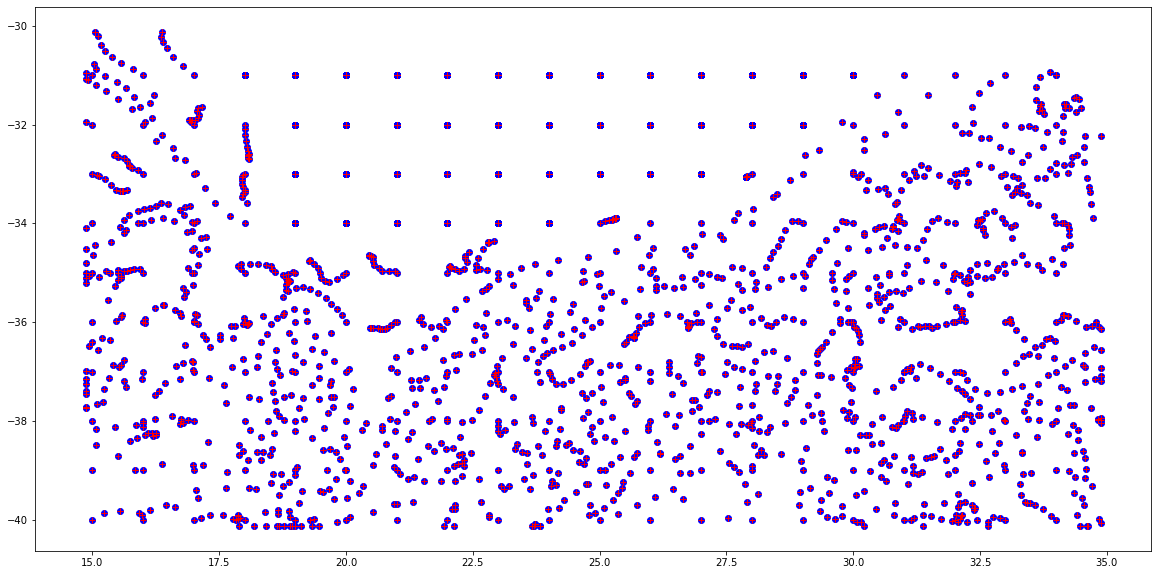

In [31]:
# Load and plot reference data
ref_out_data = netCDF4.Dataset("ref.nc")
ref_lons = ref_out_data.variables["lon"][:]
ref_lats = ref_out_data.variables["lat"][:]

fig, ax = plt.subplots(1,1,figsize=[20,10])
ax.plot(ref_lons,ref_lats,'bo')

# Load and plot incremental read/write data
for cnt in range(10):
    irw_out_file_name = "irw"+str(cnt+1).zfill(2)+".nc"
    irw_out_data = netCDF4.Dataset(irw_out_file_name)
    ids = irw_out_data.variables["trajectory"][:][:,0]
    lons = irw_out_data.variables["lon"][:]
    lats = irw_out_data.variables["lat"][:]
    ax.plot(lons,lats,'r+')

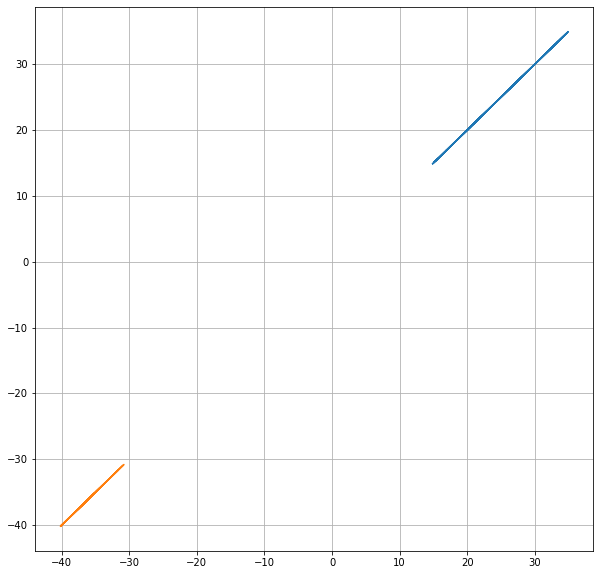

In [18]:
fig, ax = plt.subplots(1,1,figsize=[10,10])
ax.plot(ref_lons[:,-1],lons[:,-1])
ax.plot(ref_lats[:,-1],lats[:,-1])
ax.grid()

In [39]:
print(ref_lons[1,:])

[16.0 15.973499298095703 16.134756088256836 16.619098663330078
 17.090646743774414 17.62445831298828 18.095548629760742
 18.397327423095703 18.418502807617188 -- --]


In [40]:
for cnt in range(10):
    irw_out_file_name = "irw"+str(cnt+1).zfill(2)+".nc"
    irw_out_data = netCDF4.Dataset(irw_out_file_name)
    ids = irw_out_data.variables["trajectory"][:][:,0]
    lons = irw_out_data.variables["lon"][:]
    lats = irw_out_data.variables["lat"][:]
    print(lons[1,:])

[16.       15.973499]
[15.973499 16.134756]
[16.134756 16.619099]
[16.619099 17.090647]
[17.090647 17.624458]
[17.624458 18.095549]
[18.095549 18.397327]
[18.397327 18.418503]
[18.418503 18.418503]
[18.418503 18.418503]


***
# Resources

1. [Overall structure](https://github.com/OceanParcels/parcels/blob/master/parcels/examples/tutorial_parcels_structure.ipynb)
2. [Timestamps on fields](https://nbviewer.jupyter.org/github/OceanParcels/parcels/blob/master/parcels/examples/tutorial_timestamps.ipynb)
3. [Delayed starts](https://github.com/OceanParcels/parcels/blob/master/parcels/examples/tutorial_delaystart.ipynb)
4. [JIT vs SciPy particles](https://github.com/OceanParcels/parcels/blob/master/parcels/examples/tutorial_jit_vs_scipy.ipynb)
5. [Parallel OceanParcels](https://github.com/OceanParcels/parcels/blob/master/parcels/examples/documentation_MPI.ipynb)
6. [Main documentation](https://oceanparcels.org/gh-pages/html/)
7. [Plotting/Analysis examples](https://nbviewer.jupyter.org/github/OceanParcels/parcels/blob/master/parcels/examples/tutorial_output.ipynb)